## Abstract:


The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed


- https://www.kaggle.com/henriqueyamahata/bank-marketing

### Metadata

#### Datos clientes
1. age: edad del cliente
2. job: tipo de trabajo
3. marital: estado civil
4. education: nivel de educación
5. default: indica si el cliente registra algún default crediticio
5. balance: saldo en dólares de la caja de ahorro del cliente
6. housing: indica si el cliente posee un préstamo hipotecario
7. loan: indica si el cliente posee algún préstamo personal

#### Datos del último contacto de la campaña actual
9. contact: canal de contacto
10. day: día de último contacto
11. month: mes de último contacto
12. duration: duracion del último contacto
13. campaign: cantidad de contactos hechos durante la campañ para el cliente especificado

#### Otros datos
14. pdays: días transcurridos desde el último contacto por una campaña previa
15. previous: cantidad de contactos previo a esta campaña
16. poutcome: resultado de la campaña previa

#### Resultado campaña actual
17. y - Indica si el cliente realizó depósito a plazo fijo(binaria: 'yes','no')

***

- [Carga del archivo y primeros pasos](#Primeros-pasos)
- [AED](#AED)
- [Pre-procesamiento](#Pre-procesamiento)
- [Modelaje](#Modelaje)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Benchmark](#Bechmark-Final)

# Primeros pasos

Cargamos las librerías

In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [246]:
df = pd.read_csv("data.csv", sep = ";")
df.sample(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3991,31,admin.,single,secondary,no,5527,yes,no,unknown,21,may,132,1,-1,0,unknown,no
115,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes


In [247]:
df.shape

(4521, 17)

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


No tenemos valores nulos

In [249]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Vemos los valores únicos de cada variable categórica:

In [250]:
for i in list(df.select_dtypes(include='object').columns):
    print("\n Variable '{}' valores únicos: \n {}".format(i.capitalize(), df[str(i)].unique()))


 Variable 'Job' valores únicos: 
 ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']

 Variable 'Marital' valores únicos: 
 ['married' 'single' 'divorced']

 Variable 'Education' valores únicos: 
 ['primary' 'secondary' 'tertiary' 'unknown']

 Variable 'Default' valores únicos: 
 ['no' 'yes']

 Variable 'Housing' valores únicos: 
 ['no' 'yes']

 Variable 'Loan' valores únicos: 
 ['no' 'yes']

 Variable 'Contact' valores únicos: 
 ['cellular' 'unknown' 'telephone']

 Variable 'Month' valores únicos: 
 ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']

 Variable 'Poutcome' valores únicos: 
 ['unknown' 'failure' 'other' 'success']

 Variable 'Y' valores únicos: 
 ['no' 'yes']


# AED

## Variables Categóricas

Primero definimos algunas funciones para facilitar el análisis

In [251]:
def count_freq(table, variable):
    """
    Recibe una tabla y una variable categórica y
    devuelve las frecuencias
    
    args:
        table: pandas df object
        variable: str, columna o campo del df
    """
    freq = pd.DataFrame((table.groupby([str(variable)]).size().reset_index(
                                                    name='count').sort_values(
                                                    by = "count", ascending = False)))
    freq["%"] = round((freq['count'] / freq['count'].sum()) * 100, 3)
    return freq


def graf_freq(df, variable):
    """
    Recibe una tabla y una variable categórica y 
    devuelve el gráfico de frecuencias
    args:
        table: pandas df object
        variable: str, columna o campo del df
    """
    sns.countplot(x = str(variable), 
                  data = df,
                  order = df[str(variable)].value_counts().index,
                  palette="viridis")
    plt.xticks(rotation = 90)
    return plt.show()

def graf_freq_by_target(df, variable):
    """
    Recibe una tabla y una variable categórica y 
    devuelve el gráfico de frecuencias agrupado por la variable target
    args:
        table: pandas df object
        variable: str, columna o campo del df
    """
    sns.countplot(x = variable, 
              data = df,
              order = df[variable].value_counts().index,
              hue = "y",
              palette="viridis")
    plt.xticks(rotation = 90)
    plt.legend(title='Depósito a plazo fijo?', 
           loc='upper right', labels=['No', 'Yes'])
    return plt.show()

def count_freq_by_target(df, variable):
    """
    Recibe una tabla y una variable categórica y 
    devuelve una tabla de frecuencias con apertura por el target
    
    args:
        table: pandas df object
        variable: str, columna o campo del df
    """
    return pd.pivot_table(df[["y", str(variable)]],
                       index = str(variable),
                       columns = "y",
                       aggfunc= ["size"]
                       )

 

## Realizó depósito a plazo fijo

El 88.5% de los clientes no han realizado un deposito

In [252]:
count_freq(df, "y")

,y,count,%
0,no,4000,88.476
1,yes,521,11.524


## Job 


El 40% de los clientes en la muestra se centran en dos tipos de trabajos:

- Management
- Blue-collar

In [169]:
count_freq(df, "job")

,job,count,%
4,management,969,21.433
1,blue-collar,946,20.925
9,technician,768,16.987
0,admin.,478,10.573
7,services,417,9.224
5,retired,230,5.087
6,self-employed,183,4.048
2,entrepreneur,168,3.716
10,unemployed,128,2.831
3,housemaid,112,2.477


Observamos que los trabajos desconocidos y estudiantes representan la menor frecuencia

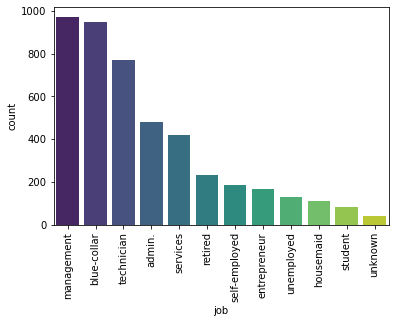

In [170]:
graf_freq(df, "job")

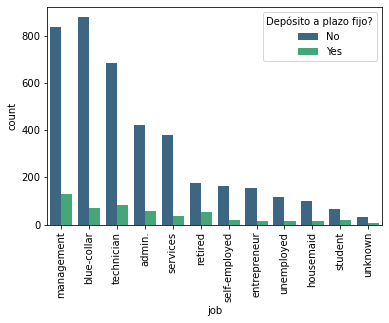

In [171]:
graf_freq_by_target(df, "job")

In [172]:
count_freq_by_target(df, "job")

size     
y               no  yes
job                    
admin.         420   58
blue-collar    877   69
entrepreneur   153   15
housemaid       98   14
management     838  131
retired        176   54
self-employed  163   20
services       379   38
student         65   19
technician     685   83
unemployed     115   13
unknown         31    7

## Estatus Marital

El 60% de los clientes se encuentra casado

In [173]:
count_freq(df, "marital")

,marital,count,%
1,married,2797,61.867
2,single,1196,26.454
0,divorced,528,11.679


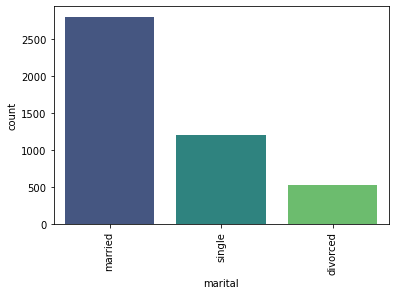

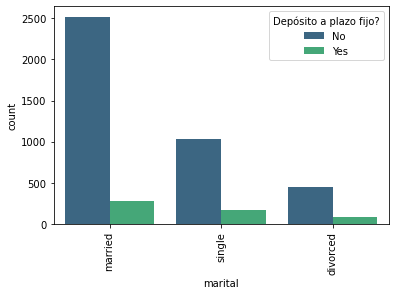

size     
y           no  yes
marital            
divorced   451   77
married   2520  277
single    1029  167

In [174]:
graf_freq(df, "marital")
graf_freq_by_target(df, "marital")
count_freq_by_target(df, "marital")

## Educación

El 50% de los clientes tiene un nivel de educación correspondiente a secundaria

In [175]:
count_freq(df, "education")

,education,count,%
1,secondary,2306,51.006
2,tertiary,1350,29.861
0,primary,678,14.997
3,unknown,187,4.136


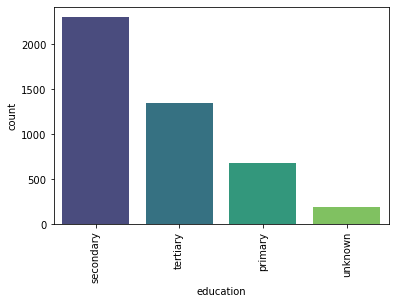

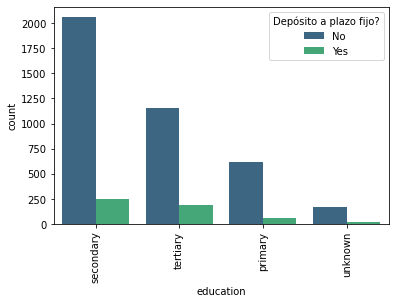

size     
y            no  yes
education           
primary     614   64
secondary  2061  245
tertiary   1157  193
unknown     168   19

In [176]:
graf_freq(df, "education")
graf_freq_by_target(df, "education")
count_freq_by_target(df, "education")

In [177]:
245 / 2061

0.11887433284813198

In [178]:
193 / 1157

0.16681071737251513

La proporción de fondeos es mayor entre las personas que tienen terceario

## Default

El porcentaje de default en los clientes es muy bajo

In [179]:
count_freq(df, "default")

,default,count,%
0,no,4445,98.319
1,yes,76,1.681


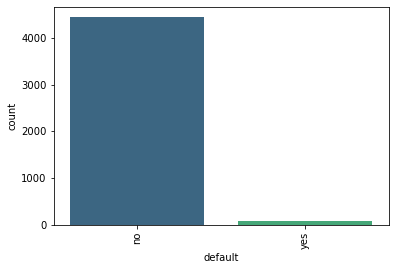

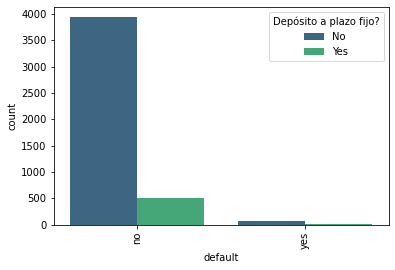

size     
y          no  yes
default           
no       3933  512
yes        67    9

In [180]:
graf_freq(df, "default")
graf_freq_by_target(df, "default")
count_freq_by_target(df, "default")

## Housing

In [181]:
count_freq(df, "housing")

,housing,count,%
1,yes,2559,56.603
0,no,1962,43.397


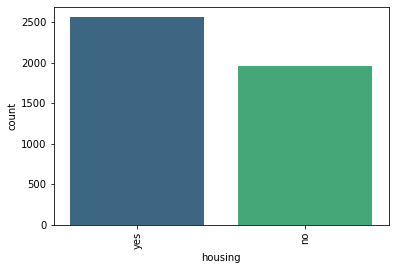

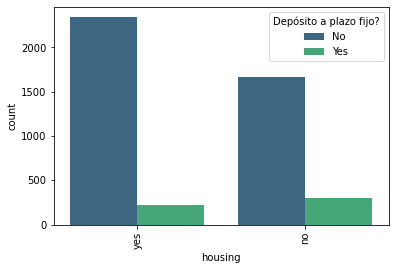

size     
y          no  yes
housing           
no       1661  301
yes      2339  220

In [182]:
graf_freq(df, "housing")
graf_freq_by_target(df, "housing")
count_freq_by_target(df, "housing")

In [183]:
301 / 1661

0.18121613485851895

In [184]:
220 / 2339

0.0940572894399316

La proporción de clientes que no tienen casa e hicieron el depósito es mayor.

## Loan

In [185]:
count_freq(df, "loan")

,loan,count,%
0,no,3830,84.716
1,yes,691,15.284


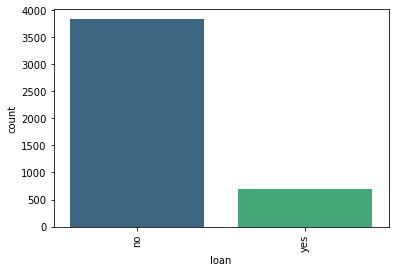

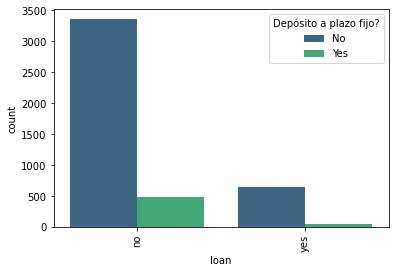

size     
y       no  yes
loan           
no    3352  478
yes    648   43

In [186]:
graf_freq(df, "loan")
graf_freq_by_target(df, "loan")
count_freq_by_target(df, "loan")

Las personas que tienen un préstamo con la institución no realizan por lo general el depósito

## Contact

In [187]:
count_freq(df, "contact")

,contact,count,%
0,cellular,2896,64.057
2,unknown,1324,29.286
1,telephone,301,6.658


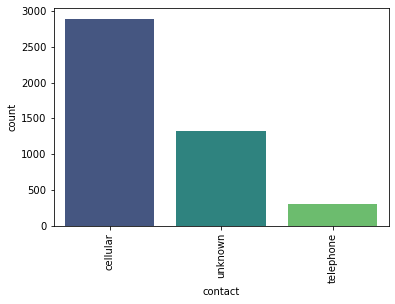

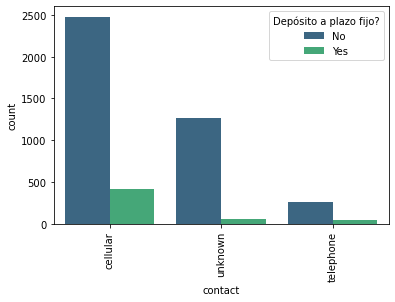

size     
y            no  yes
contact             
cellular   2480  416
telephone   257   44
unknown    1263   61

In [188]:
graf_freq(df, "contact")
graf_freq_by_target(df, "contact")
count_freq_by_target(df, "contact")

La proporción de clientes que realizaron el plazo fijo es similar cuando el contacto es por celular o telf fijo

In [189]:
416 / 2480

0.16774193548387098

In [190]:
44 / 257

0.17120622568093385

In [191]:
61 / 1263

0.04829770387965162

## Month

In [192]:
count_freq(df, "month")


,month,count,%
8,may,1398,30.922
5,jul,706,15.616
1,aug,633,14.001
6,jun,531,11.745
9,nov,389,8.604
0,apr,293,6.481
3,feb,222,4.910
4,jan,148,3.274
10,oct,80,1.770
11,sep,52,1.150


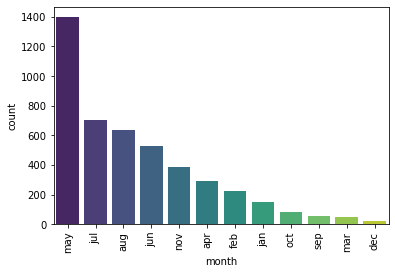

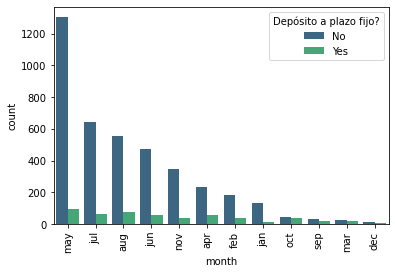

size    
y        no yes
month          
apr     237  56
aug     554  79
dec      11   9
feb     184  38
jan     132  16
jul     645  61
jun     476  55
mar      28  21
may    1305  93
nov     350  39
oct      43  37
sep      35  17

In [193]:
graf_freq(df, "month")
graf_freq_by_target(df, "month")
count_freq_by_target(df, "month")

Diciembre, marzo y octubre fueron los meses más efectivos en la captación de nuevos depósitos

In [194]:
c = count_freq_by_target(df, "month").reset_index()

c["%"] = c["size"]["yes"] / c["size"]["no"] * 100
c

month  size              %
y           no yes           
0    apr   237  56  23.628692
1    aug   554  79  14.259928
2    dec    11   9  81.818182
3    feb   184  38  20.652174
4    jan   132  16  12.121212
5    jul   645  61   9.457364
6    jun   476  55  11.554622
7    mar    28  21  75.000000
8    may  1305  93   7.126437
9    nov   350  39  11.142857
10   oct    43  37  86.046512
11   sep    35  17  48.571429

## Poutcome

In [195]:
count_freq(df, "poutcome")



,poutcome,count,%
3,unknown,3705,81.951
0,failure,490,10.838
1,other,197,4.357
2,success,129,2.853


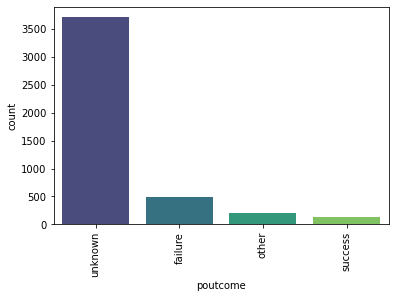

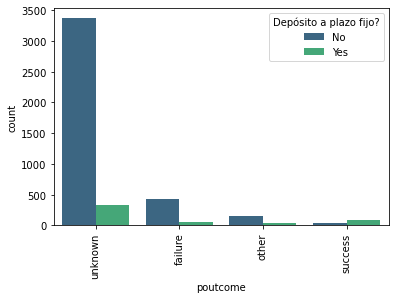

size     
y           no  yes
poutcome           
failure    427   63
other      159   38
success     46   83
unknown   3368  337

In [196]:
graf_freq(df, "poutcome")
graf_freq_by_target(df, "poutcome")
count_freq_by_target(df, "poutcome")

## Variables Númericas

- No se observan diferencias en los estadísticos de tendencia central en los grupos del target en relación a la edad.
- La mediana del balance es mayor en los clientes que terminaron haciendo el depósito
- La mediana y la media de la duración son mayores en el grupo que si hizo el depósito a plazo fijo


In [197]:
pd.DataFrame(df.groupby("y").describe()).T

y                         no           yes
age      count   4000.000000    521.000000
         mean      40.998000     42.491363
         std       10.188398     13.115772
         min       19.000000     19.000000
         25%       33.000000     32.000000
         50%       39.000000     40.000000
         75%       48.000000     50.000000
         max       86.000000     87.000000
balance  count   4000.000000    521.000000
         mean    1403.211750   1571.955854
         std     3075.349313   2444.398956
         min    -3313.000000  -1206.000000
         25%       61.000000    171.000000
         50%      419.500000    710.000000
         75%     1407.000000   2160.000000
         max    71188.000000  26965.000000
day      count   4000.000000    521.000000
         mean      15.948750     15.658349
         std        8.249736      8.235148
         min        1.000000      1.000000
         25%        8.000000      9.000000
         50%       16.000000     15.000000
         75%       21.000000     22.000000
         max       31.000000     31.000000
duration count   4000.000000    521.000000
         mean     226.347500    552.742802
         std      210.313631    390.325805
         min        4.000000     30.000000
         25%       96.000000    260.000000
         50%      167.000000    442.000000
         75%      283.000000    755.000000
         max     3025.000000   2769.000000
campaign count   4000.000000    521.000000
         mean       2.862250      2.266795
         std        3.212609      2.092071
         min        1.000000      1.000000
         25%        1.000000      1.000000
         50%        2.000000      2.000000
         75%        3.000000      3.000000
         max       50.000000     24.000000
pdays    count   4000.000000    521.000000
         mean      36.006000     68.639155
         std       96.297657    121.963063
         min       -1.000000     -1.000000
         25%       -1.000000     -1.000000
         50%       -1.000000     -1.000000
         75%       -1.000000     98.000000
         max      871.000000    804.000000
previous count   4000.000000    521.000000
         mean       0.471250      1.090211
         std        1.627371      2.055368
         min        0.000000      0.000000
         25%        0.000000      0.000000
         50%        0.000000      0.000000
         75%        0.000000      2.000000
         max       25.000000     14.000000

No se observaron correlaciones altas

In [253]:
df.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.083820,-0.017853,-0.002367,-0.005148,-0.008894,-0.003511
balance,0.083820,1.000000,-0.008677,-0.015950,-0.009976,0.009437,0.026196
day,-0.017853,-0.008677,1.000000,-0.024629,0.160706,-0.094352,-0.059114
duration,-0.002367,-0.015950,-0.024629,1.000000,-0.068382,0.010380,0.018080
campaign,-0.005148,-0.009976,0.160706,-0.068382,1.000000,-0.093137,-0.067833
pdays,-0.008894,0.009437,-0.094352,0.010380,-0.093137,1.000000,0.577562
previous,-0.003511,0.026196,-0.059114,0.018080,-0.067833,0.577562,1.000000


In [199]:
list(df.corr().columns)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Balance, duration, pdays y previus presentan distribuciones coleadas


 Age 



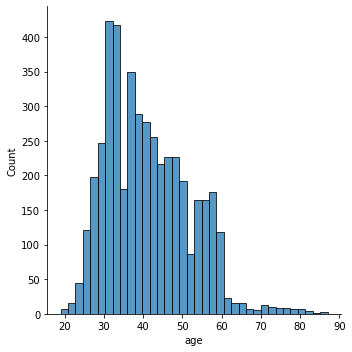


 Balance 



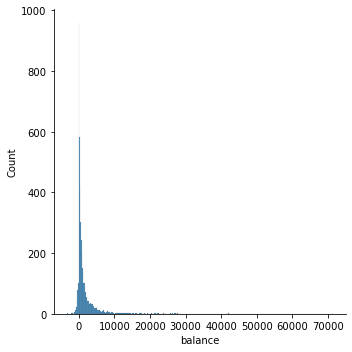


 Day 



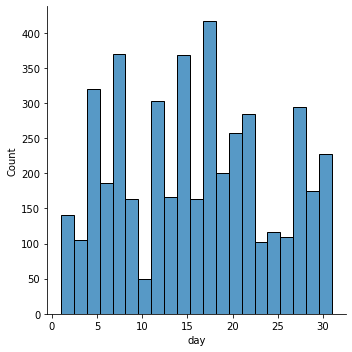


 Duration 



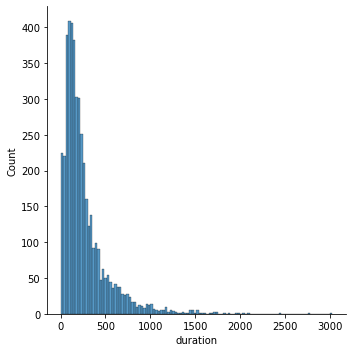


 Campaign 



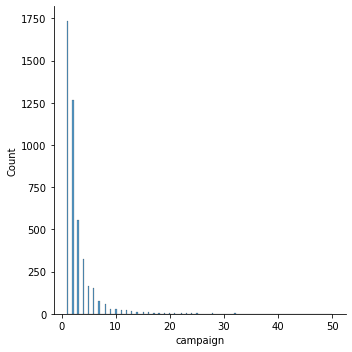


 Pdays 



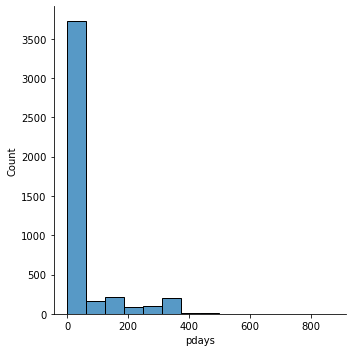


 Previous 



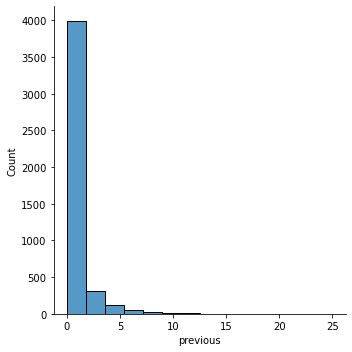

In [200]:
for i in list(df.corr().columns):
    print("\n {} \n".format(i.capitalize()))
    sns.displot(df, x = str(i))
    plt.show()

Se observan distribuciones similares de edad entre los clientes que hicieron el depósito y los que no


 Age 



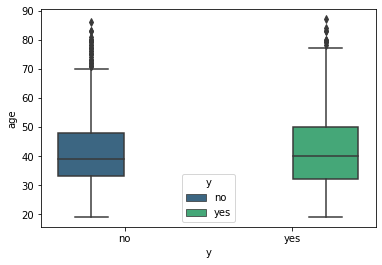


 Balance 



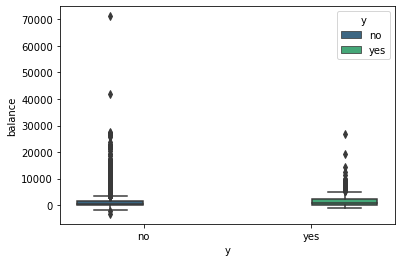


 Day 



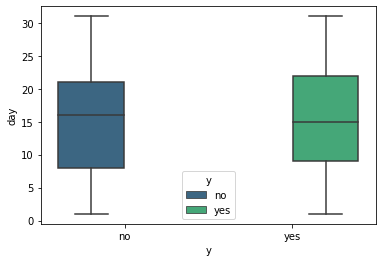


 Duration 



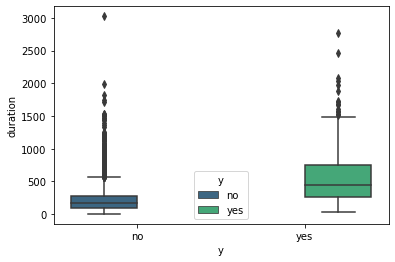


 Campaign 



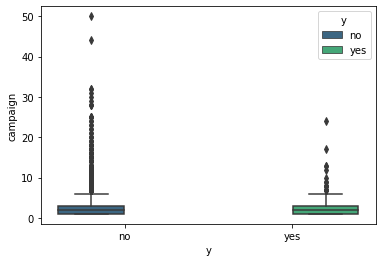


 Pdays 



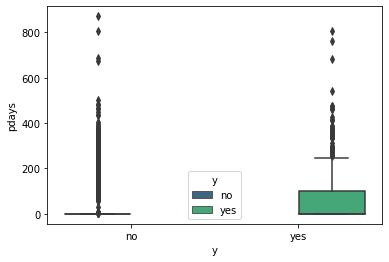


 Previous 



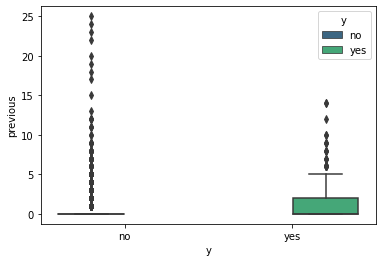

In [201]:
for i in list(df.corr().columns):
    print("\n {} \n".format(i.capitalize()))
    sns.boxplot(x="y", y = str(i),
               hue="y", palette="viridis",
               data=df)
    plt.show()
        #return 

## Pre procesamiento

Filtramos y sacamos los registros con Unknowm en educación para darle a la variable el tratamiento de ordinal y poder asignarle etiquetas númericas

In [254]:
df = df[df["education"] != "unknown"]

Hacemos label encoder sobre la educación y asumimos que es una variable ordinal

In [255]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["education"] = label_encoder.fit_transform(df["education"]) 

In [256]:
df["education"].head()

0    0
1    1
2    2
3    2
4    1
Name: education, dtype: int32

Pasamos a dummy las variable categóricas

In [257]:
jobs = pd.get_dummies(df.job, drop_first=False, prefix="job", prefix_sep="_")
jobs.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


borramos el unknow:

In [258]:
jobs = jobs.iloc[:,0:11]
jobs.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0


In [262]:
marital = pd.get_dummies(df.marital, drop_first = True, prefix="marital", prefix_sep="_")

In [263]:
default = pd.get_dummies(df.default, drop_first = True, prefix="default", prefix_sep="_")

In [264]:
housing = pd.get_dummies(df.housing, drop_first = True, prefix="housing", prefix_sep="_")

In [265]:
loan = pd.get_dummies(df.loan, drop_first = True, prefix="loan", prefix_sep="_")

In [266]:
contact = pd.get_dummies(df.contact, prefix="contact", prefix_sep="_")
contact = contact[["contact_cellular", "contact_telephone"]]

In [267]:
month = pd.get_dummies(df.month, drop_first = True, prefix="month", prefix_sep="_")

In [268]:
poutcome = pd.get_dummies(df.poutcome, drop_first = True, prefix="poutcome", prefix_sep="_")

Concatenamos todo y borramos la variables que fueron pre procesadas

In [269]:
data = pd.concat([df, 
                  jobs, 
                  marital, 
                  default, 
                  housing, 
                  loan, 
                  contact, 
                  month,
                  poutcome], 
                  axis=1)

data.drop(['job', 
           'marital', 
           'job', 
           'default', 
           'marital', 
           'housing', 
           'loan',
           'contact',
           'month',
           'poutcome'
                  ], 
            axis = 1, inplace = True)
data.head()

,age,education,balance,day,duration,campaign,pdays,previous,y,job_admin.,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,19,79,1,-1,0,no,0,...,0,0,0,0,0,1,0,0,0,1
1,33,1,4789,11,220,1,339,4,no,0,...,0,0,0,1,0,0,0,0,0,0
2,35,2,1350,16,185,1,330,1,no,0,...,0,0,0,0,0,0,0,0,0,0
3,30,2,1476,3,199,4,-1,0,no,0,...,0,1,0,0,0,0,0,0,0,1
4,59,1,0,5,226,1,-1,0,no,0,...,0,0,0,1,0,0,0,0,0,1


In [270]:
col = list(data.columns)
col.remove("y")
col

['age',
 'education',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_married',
 'marital_single',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

In [271]:
col = list("y") + col

Re ordenamos el DF

In [272]:
data = data[col]
data.head()

,y,age,education,balance,day,duration,campaign,pdays,previous,job_admin.,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,no,30,0,1787,19,79,1,-1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,no,33,1,4789,11,220,1,339,4,0,...,0,0,0,1,0,0,0,0,0,0
2,no,35,2,1350,16,185,1,330,1,0,...,0,0,0,0,0,0,0,0,0,0
3,no,30,2,1476,3,199,4,-1,0,0,...,0,1,0,0,0,0,0,0,0,1
4,no,59,1,0,5,226,1,-1,0,0,...,0,0,0,1,0,0,0,0,0,1


Reemplazamos valores en el target

In [273]:
data["y"].replace({"yes": "1", "no": "0"}, inplace=True)

In [274]:
data["y"].unique()

array(['0', '1'], dtype=object)

In [275]:
data["y"] = data["y"].astype(int)

In [276]:
data.sample(10)

,y,age,education,balance,day,duration,campaign,pdays,previous,job_admin.,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3258,0,38,1,0,28,121,2,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
3786,1,74,1,921,17,394,2,-1,0,0,...,0,0,0,0,0,0,0,0,0,1
505,0,31,1,296,20,378,3,-1,0,0,...,0,0,0,1,0,0,0,0,0,1
2110,0,31,1,-498,21,357,1,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
109,0,27,0,0,23,435,3,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
3075,0,47,1,3285,31,248,5,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
1522,0,39,0,238,19,134,1,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
1359,0,35,0,0,14,340,3,-1,0,0,...,1,0,0,0,0,0,0,0,0,1
83,1,52,1,657,7,398,2,460,2,0,...,1,0,0,0,0,0,0,0,0,0
1737,0,59,1,345,9,38,1,-1,0,0,...,0,1,0,0,0,0,0,0,0,1


Se ha notado que tenemos valores negativos en pdays. Lo cual podría no tener mucho sentido, se procederá a reemplazarlos por ceros.

In [277]:
data["pdays"].replace({-1: 0}, inplace=True)

In [278]:
dataoriginal=data.copy()

In [358]:
#data=dataoriginal

In [359]:
data.head(1)

,y,age,education,balance,day,duration,campaign,pdays,previous,job_admin.,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,balanceage,balancecua,agecua
0,0,30,0,1787,19,79,1,0,0,0,...,0,0,1,0,0,0,1,59.566667,3193369,900


In [226]:
#def mean_norm(df_input):
#    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [227]:
#data[['age']]=mean_norm(data[['age']])
#data[['education']]=mean_norm(data[['education']])
#data[['balance']]=mean_norm(data[['balance']])
#data[['day']]=mean_norm(data[['day']])
#data[['duration']]=mean_norm(data[['duration']])

## Feature Engineering

In [360]:
data['balanceage'] = df['balance'] / df['age']
data['agecua'] = df['age'] * df['age']
data['ageday'] = df['age'] * df['day']
data['balanceday'] = df['balance'] / df['day']

Desordenamos de forma aleatoria el df y además nos guardamos una porción de data para validación final

In [361]:
data = data.sample(data.shape[0]).reset_index(drop = True)

data_validacion = data[0:100]
data_2 = data[100:]

In [362]:
data_validacion.head()

,y,age,education,balance,day,duration,campaign,pdays,previous,job_admin.,...,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,balanceage,balancecua,agecua,ageday,balanceday
0,0,31,1,1987,20,55,2,0,0,0,...,0,0,0,0,1,64.096774,3948169,961,620,99.350000
1,0,47,2,3681,14,101,2,0,0,0,...,0,0,0,0,1,78.319149,13549761,2209,658,262.928571
2,0,43,1,634,17,65,1,131,1,0,...,0,0,0,0,0,14.744186,401956,1849,731,37.294118
3,0,32,1,739,9,171,1,0,0,0,...,0,0,0,0,1,23.093750,546121,1024,288,82.111111
4,0,58,1,111,24,58,2,0,0,0,...,0,0,0,0,1,1.913793,12321,3364,1392,4.625000


In [363]:
data_2.head()

,y,age,education,balance,day,duration,campaign,pdays,previous,job_admin.,...,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,balanceage,balancecua,agecua,ageday,balanceday
100,0,58,0,781,15,74,2,0,0,0,...,0,0,0,0,1,13.465517,609961,3364,870,52.066667
101,0,33,1,3576,2,124,1,308,2,0,...,0,0,1,0,0,108.363636,12787776,1089,66,1788.000000
102,1,59,2,2013,19,222,4,94,2,0,...,0,0,0,1,0,34.118644,4052169,3481,1121,105.947368
103,0,26,1,0,27,755,1,0,0,1,...,0,0,0,0,1,0.000000,0,676,702,0.000000
104,0,54,2,7010,11,275,2,0,0,0,...,0,0,0,0,1,129.814815,49140100,2916,594,637.272727


## Muestreo

In [364]:
X = data_2.loc[:, data.columns != 'y']
y = data_2["y"]

X_validacion = data_validacion.loc[:, data.columns != 'y']
y_validacion = data_validacion["y"]

In [233]:
#X.to_csv('X_train.csv', header=False, index=False) y.to_csv('y_train.csv', header=False, index=False) 

Normalizamos los datos

In [365]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_validacion = sc.fit_transform(X_validacion)

In [366]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [367]:
import numpy as np
np.save('X_train.npy',X_train)
np.save('y_train.npy',y_train)
np.save('X_test.npy',X_test)
np.save('y_test.npy',y_test)

## Modelaje

Regresión Logística

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate


regresion_logistica = LogisticRegression()

regresion_logistica.fit(X_train, y_train)

regresion_logistica_pred = regresion_logistica.predict(X_test)

print(classification_report(y_test, regresion_logistica_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2806
           1       0.64      0.32      0.43       369

    accuracy                           0.90      3175
   macro avg       0.78      0.65      0.69      3175
weighted avg       0.88      0.90      0.89      3175



In [7]:
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, regresion_logistica_pred))


Confusion Matrix:
 [[2741   65]
 [ 251  118]]


De los 947 ejemplos negativo, 912 han sido clasificados como negativos (93%);
mientras que de los 112 ejemplos positivos, solo 71 (54%).

Corremos una validación cruzada para la regresión logística

In [12]:
regresion_logistica_CV = cross_validate(regresion_logistica, 
                                        X, y, cv=5, 
                                        scoring = ['precision','recall', 'accuracy', 'f1'])

In [15]:
evaluacion = pd.DataFrame(regresion_logistica_CV)
evaluacion["Algoritmo"] = "Regresión Logística"
evaluacion

,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1,Algoritmo
0,0.043001,0.005001,0.633333,0.260274,0.897638,0.368932,Regresión Logística
1,0.053003,0.004001,0.615385,0.324324,0.897638,0.424779,Regresión Logística
2,0.034002,0.006000,0.592593,0.216216,0.891339,0.316832,Regresión Logística
3,0.030001,0.004003,0.680851,0.432432,0.910236,0.528926,Regresión Logística
4,0.033002,0.003002,0.500000,0.283784,0.883465,0.362069,Regresión Logística


Árbol de decisión

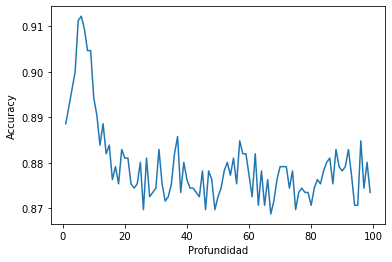

In [372]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

profundidad = list(range(1,100))

scores = []


for i in profundidad:
    arbol_d = DecisionTreeClassifier(max_depth=i)
    arbol_d.fit(X_train, y_train)
    arbol_d_pred = arbol_d.predict(X_test)
    sck = accuracy_score(y_test, arbol_d_pred)
    scores.append(sck)


plt.plot(profundidad, scores)
plt.xlabel('Profundidad')
plt.ylabel('Accuracy')
plt.show()

In [373]:
from sklearn.tree import DecisionTreeClassifier

arbol_d = DecisionTreeClassifier(max_depth=5)

arbol_d.fit(X_train, y_train)
arbol_d_pred = arbol_d.predict(X_test)

print(classification_report(y_test, arbol_d_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       941
           1       0.72      0.32      0.44       118

    accuracy                           0.91      1059
   macro avg       0.82      0.65      0.70      1059
weighted avg       0.90      0.91      0.89      1059



In [374]:
arbol_d_CV = cross_validate(arbol_d, 
                            X, y, cv=5, 
                            scoring = ['precision','recall', 'accuracy', 'f1'])

In [379]:
evaluacion_2 = pd.DataFrame(arbol_d_CV)
evaluacion_2["Algoritmo"] = "Árbol de decisión"
evaluacion_2

,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1,Algoritmo
0,0.016005,0.008006,0.568966,0.340206,0.894923,0.425806,Árbol de decisión
1,0.015997,0.008008,0.672727,0.381443,0.907910,0.486842,Árbol de decisión
2,0.015996,0.008006,0.660377,0.357143,0.904368,0.463576,Árbol de decisión
3,0.016000,0.000000,0.584906,0.316327,0.894923,0.410596,Árbol de decisión
4,0.024010,0.000000,0.512195,0.216495,0.886525,0.304348,Árbol de decisión


XGboost

In [381]:
from xgboost import XGBClassifier

In [382]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgbprd = xgb.predict(X_test)

print(classification_report(y_test, xgbprd))

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:34] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       941
           1       0.65      0.43      0.52       118

    accuracy                           0.91      1059
   macro avg       0.79      0.70      0.74      1059
weighted avg       0.90      0.91      0.90      1059



In [384]:
xgb_CV = cross_validate(xgb, 
                        X, y, cv=5, 
                        scoring = ['precision','recall', 'accuracy', 'f1'])

C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\HP\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:59] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [385]:
evaluacion_3 = pd.DataFrame(xgb_CV)
evaluacion_3["Algoritmo"] = "XG-Boost"
evaluacion_3

,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1,Algoritmo
0,0.379596,0.008042,0.567164,0.391753,0.896104,0.463415,XG-Boost
1,0.352717,0.010098,0.597015,0.412371,0.900826,0.487805,XG-Boost
2,0.352474,0.009999,0.655738,0.408163,0.906730,0.503145,XG-Boost
3,0.357768,0.010051,0.571429,0.326531,0.893743,0.415584,XG-Boost
4,0.382642,0.010091,0.567568,0.432990,0.897163,0.491228,XG-Boost


SVM

In [16]:
from sklearn import svm

support_vm = svm.SVC()

support_vm.fit(X_train, y_train)
support_vm_pred = support_vm.predict(X_test)

print(classification_report(y_test, support_vm_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2806
           1       0.91      0.34      0.50       369

    accuracy                           0.92      3175
   macro avg       0.91      0.67      0.73      3175
weighted avg       0.92      0.92      0.90      3175



In [17]:
support_vm_CV = cross_validate(support_vm, 
                        X, y, cv=5, 
                        scoring = ['precision','recall', 'accuracy', 'f1'])

In [18]:
evaluacion_4 = pd.DataFrame(support_vm_CV)
evaluacion_4["Algoritmo"] = "SVM"
evaluacion_4

,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1,Algoritmo
0,0.207516,0.113006,0.578947,0.150685,0.889764,0.239130,SVM
1,0.207014,0.113010,0.555556,0.135135,0.886614,0.217391,SVM
2,0.176015,0.117010,0.562500,0.121622,0.886614,0.200000,SVM
3,0.192014,0.114010,0.518519,0.189189,0.885039,0.277228,SVM
4,0.205013,0.110008,0.600000,0.162162,0.889764,0.255319,SVM


K Vecinos:

<br> 
</br>

Para correr K-vecinos primero estimaremos cuál sería el número de vecinos óptimos

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

vecinos = list(range(1,36))

scores = []


for i in vecinos:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    sck = accuracy_score(y_test, knn_pred)
    scores.append(sck)


plt.plot(vecinos, scores)
plt.xlabel('Número de Vecinos')
plt.ylabel('Accuracy')
plt.show()

AttributeError: module 'matplotlib' has no attribute 'plot'

Nos quedamos con 4, dado a que después de ese número las ganancias son pocas

In [391]:
knn = KNeighborsClassifier(n_neighbors = 4)

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       941
           1       0.50      0.16      0.24       118

    accuracy                           0.89      1059
   macro avg       0.70      0.57      0.59      1059
weighted avg       0.86      0.89      0.86      1059



In [392]:
knn_CV = cross_validate(knn, 
                        X, y, cv=5, 
                        scoring = ['precision','recall', 'accuracy', 'f1'])

In [393]:
evaluacion_5 = pd.DataFrame(knn_CV)
evaluacion_5["Algoritmo"] = "Knn"
evaluacion_5

,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1,Algoritmo
0,0.003012,0.112993,0.444444,0.123711,0.881936,0.193548,Knn
1,0.002000,0.085314,0.592593,0.164948,0.891381,0.258065,Knn
2,0.012506,0.100292,0.608696,0.142857,0.890201,0.231405,Knn
3,0.015633,0.102599,0.666667,0.122449,0.891381,0.206897,Knn
4,0.000000,0.114339,0.684211,0.134021,0.893617,0.224138,Knn


Realizaremos un procedimiento similar para estimar 

In [394]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)


print(classification_report(y_test, random_forest_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       941
           1       0.78      0.21      0.33       118

    accuracy                           0.91      1059
   macro avg       0.85      0.60      0.64      1059
weighted avg       0.90      0.91      0.88      1059



In [395]:
random_forest_CV = cross_validate(RandomForestClassifier(n_estimators = 100), 
                        X, y, cv=5, 
                        scoring = ['precision','recall', 'accuracy', 'f1'])

In [396]:
evaluacion_6 = pd.DataFrame(knn_CV)
evaluacion_6["Algoritmo"] = "Random Forest"
evaluacion_6

,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1,Algoritmo
0,0.003012,0.112993,0.444444,0.123711,0.881936,0.193548,Random Forest
1,0.002000,0.085314,0.592593,0.164948,0.891381,0.258065,Random Forest
2,0.012506,0.100292,0.608696,0.142857,0.890201,0.231405,Random Forest
3,0.015633,0.102599,0.666667,0.122449,0.891381,0.206897,Random Forest
4,0.000000,0.114339,0.684211,0.134021,0.893617,0.224138,Random Forest


In [397]:
ev = pd.concat([evaluacion, evaluacion_2, evaluacion_3, evaluacion_4, evaluacion_5, evaluacion_6])

ev.groupby("Algoritmo").mean().reset_index()

,Algoritmo,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1
0,Knn,0.006630,0.103107,0.599322,0.137597,0.889703,0.222810
1,Random Forest,0.006630,0.103107,0.599322,0.137597,0.889703,0.222810
2,Regresión Logística,0.037327,0.003202,0.632894,0.312266,0.900094,0.415968
3,SVM,0.252991,0.146001,0.669428,0.193057,0.895842,0.296918
4,XG-Boost,0.365039,0.009656,0.591783,0.394361,0.898913,0.472235
5,Árbol de decisión,0.017602,0.004804,0.599834,0.322323,0.897730,0.418234


In [398]:
ev = pd.concat([evaluacion, evaluacion_2, evaluacion_3, evaluacion_4, evaluacion_5, evaluacion_6])

ev.groupby("Algoritmo").std().reset_index()

,Algoritmo,fit_time,score_time,test_precision,test_recall,test_accuracy,test_f1
0,Knn,0.006965,0.011712,0.094686,0.017399,0.004515,0.024637
1,Random Forest,0.006965,0.011712,0.094686,0.017399,0.004515,0.024637
2,Regresión Logística,0.011346,0.004385,0.051356,0.063349,0.007027,0.060537
3,SVM,0.008039,0.011848,0.094115,0.045345,0.005126,0.055870
4,XG-Boost,0.014869,0.000903,0.037830,0.040666,0.005061,0.034805
5,Árbol de decisión,0.003582,0.004385,0.066774,0.063763,0.008500,0.070443


## Hyperparameter Tuning

SVM

Correr con todos los parámetros tarda muchísimo, por eso solo se dejó "C"

In [420]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svc_params = {'C': [10000],
             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
             'degree': [2,3,4]
            }
svc = svm.SVC()
model_svc = GridSearchCV(svc, 
                        param_grid = svc_params,  
                        scoring = 'accuracy')

model_svc.fit(X, y)


In [ ]:
modelos_svc = pd.DataFrame(model_svc.cv_results_)
modelos_svc = modelos_lg.sort_values('rank_test_score',ascending=True).head()
modelos_svc

Regresión Logística

In [281]:
from sklearn.model_selection import GridSearchCV

lg_params = {#'penalty': ['l1','l2'], 
             'C': [0.001,0.01,0.1,1,10,100,1000],
             #'max_iter': list(range(100,800)),
             #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }

model_lr = GridSearchCV(LogisticRegression(), 
                        param_grid = lg_params, 
                        scoring = 'accuracy')

model_lr.fit(X, y)


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [141]:
modelos_lg = pd.DataFrame(model_lr.cv_results_)
modelos_lg = modelos_lg.sort_values('rank_test_score',ascending=True).head()
modelos_lg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.018756,0.006251,0.0,0.0,100,{'C': 100},0.904368,0.903188,0.889020,0.898465,0.898345,0.898677,0.005406,1
6,0.018755,0.006252,0.0,0.0,1000,{'C': 1000},0.904368,0.903188,0.889020,0.898465,0.898345,0.898677,0.005406,1
3,0.018756,0.006252,0.0,0.0,1,{'C': 1},0.904368,0.903188,0.887839,0.898465,0.898345,0.898441,0.005832,3
4,0.018756,0.006253,0.0,0.0,10,{'C': 10},0.904368,0.903188,0.887839,0.898465,0.898345,0.898441,0.005832,3
2,0.008580,0.007201,0.0,0.0,0.1,{'C': 0.1},0.902007,0.904368,0.889020,0.897285,0.898345,0.898205,0.005247,5


In [108]:
tree_params = {'criterion':['gini','entropy'],
               'max_depth':[2,3,4,5,6,7,8,9,10]}

model_tree = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid = tree_params,
                          scoring = 'accuracy')
model_tree.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [109]:
modelos_tree = pd.DataFrame(model_tree.cv_results_)
modelos_tree = modelos_tree.sort_values('rank_test_score',ascending=True).head()
modelos_tree

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.016391,0.002332,0.001200,9.787325e-04,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.909091,0.905549,0.892562,0.889020,0.901891,0.899623,0.007644,1
2,0.020116,0.014022,0.000999,5.840039e-07,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.904368,0.903188,0.890201,0.892562,0.904255,0.898915,0.006210,2
7,0.022955,0.006046,0.001400,4.891281e-04,gini,9,"{'criterion': 'gini', 'max_depth': 9}",0.893743,0.906730,0.889020,0.886659,0.914894,0.898209,0.010851,3
11,0.012392,0.000490,0.001000,1.112166e-06,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.902007,0.907910,0.892562,0.884298,0.900709,0.897497,0.008218,4
5,0.016517,0.001048,0.000600,7.998467e-04,gini,7,"{'criterion': 'gini', 'max_depth': 7}",0.893743,0.909091,0.886659,0.884298,0.911348,0.897027,0.011233,5


In [114]:
xgb_params =    {
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [50, 100, 150],
            #'gamma': [0, 0.1, 0.2],
            #'min_child_weight': [0, 0.5, 1],
            #'max_delta_step': [0],
            #'subsample': [0.7, 0.8, 0.9, 1],
            #'colsample_bytree': [0.6, 0.8, 1],
            #'colsample_bylevel': [1],
            #'reg_alpha': [0, 1e-2, 1, 1e1],
            #'reg_lambda': [0, 1e-2, 1, 1e1],
            #'base_score': [0.5]
            }



model_xgb = GridSearchCV(XGBClassifier(), 
                        xgb_params, 
                        scoring = 'accuracy', n_jobs=-1)

model_xgb.fit(X,y)



C:\Users\victor.ayala\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
  

In [115]:
modelos_xgb = pd.DataFrame(model_xgb.cv_results_)
modelos_xgb = modelos_xgb.sort_values('rank_test_score',ascending=True).head()
modelos_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,4.287941,0.279241,0.011395,0.002058,0.2,5,150,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.897285,0.910272,0.902007,0.891381,0.905437,0.901276,0.006521,1
11,2.928428,0.140347,0.011194,0.001599,0.2,3,150,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.894923,0.913813,0.893743,0.885478,0.917258,0.901043,0.012321,2
15,1.186120,0.147515,0.008195,0.000979,0.2,5,50,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.898465,0.910272,0.896104,0.890201,0.907801,0.900569,0.007461,3
16,2.212132,0.209445,0.009995,0.002097,0.2,5,100,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.896104,0.907910,0.896104,0.891381,0.910165,0.900333,0.007348,4
10,1.765588,0.173436,0.010195,0.000979,0.2,3,100,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.894923,0.909091,0.893743,0.887839,0.914894,0.900098,0.010171,5


## Bechmark Final

In [120]:
modelos_lg.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.030184,0.006641,0.000999,7.294206e-07,0.1,{'C': 0.1},0.90791,0.913813,0.886659,0.897285,0.905437,0.902221,0.00942,1


In [128]:
modelo_final_log = LogisticRegression(C = 1.0)

modelo_final_log.fit(X, y)
modelo_final_log_pred = modelo_final_log.predict(X_validacion)


print(classification_report(y_validacion, modelo_final_log_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        90
           1       0.40      0.20      0.27        10

    accuracy                           0.89       100
   macro avg       0.66      0.58      0.60       100
weighted avg       0.86      0.89      0.87       100



In [127]:
modelos_tree.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.016391,0.002332,0.0012,0.000979,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.909091,0.905549,0.892562,0.88902,0.901891,0.899623,0.007644,1


In [129]:
modelo_final_tree = DecisionTreeClassifier(criterion='gini', max_depth=3)

modelo_final_tree.fit(X, y)
modelo_final_tree_pred = modelo_final_tree.predict(X_validacion)


print(classification_report(y_validacion, modelo_final_tree_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        90
           1       0.29      0.20      0.24        10

    accuracy                           0.87       100
   macro avg       0.60      0.57      0.58       100
weighted avg       0.85      0.87      0.86       100



In [134]:
modelos_xgb.to_excel("modelos.xlsx", index = False)

In [133]:
modelos_xgb.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,4.287941,0.279241,0.011395,0.002058,0.2,5,150,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.897285,0.910272,0.902007,0.891381,0.905437,0.901276,0.006521,1


In [132]:
print(modelos_xgb["params"].head(1))

17    {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...
Name: params, dtype: object


In [137]:
modelo_final_xgb = XGBClassifier(learning_rate = 0.2, 
                                 max_depth = 5, 
                                 n_estimators= 150)

modelo_final_xgb.fit(X, y)
modelo_final_xgb_pred = modelo_final_xgb.predict(X_validacion)


print(classification_report(y_validacion, modelo_final_xgb_pred))

C:\Users\victor.ayala\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        90
           1       0.40      0.20      0.27        10

    accuracy                           0.89       100
   macro avg       0.66      0.58      0.60       100
weighted avg       0.86      0.89      0.87       100



In [143]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Regresión Logística: ROC AUC = 0.872
Árbol de decisión: ROC AUC = 0.821
XGBoost: ROC AUC = 0.896


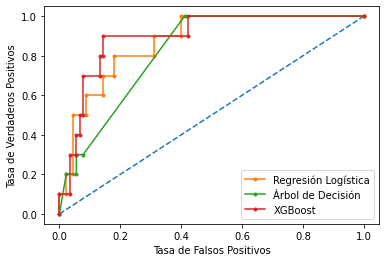

In [166]:
ns_probs = [0 for _ in range(len(y_validacion))]

log_probs = modelo_final_log.predict_proba(X_validacion)
log_probs = log_probs[:, 1]

tree_probs = modelo_final_tree.predict_proba(X_validacion)
tree_probs = tree_probs[:, 1]

xgb_probs = modelo_final_xgb.predict_proba(X_validacion)
xgb_probs = xgb_probs[:, 1]

ns_auc = roc_auc_score(y_validacion, ns_probs)

log_auc = roc_auc_score(y_validacion, log_probs)
tree_auc = roc_auc_score(y_validacion, tree_probs)
xgb_auc = roc_auc_score(y_validacion, xgb_probs)

print('Regresión Logística: ROC AUC = %.3f' % (log_auc))
print('Árbol de decisión: ROC AUC = %.3f' % (tree_auc))
print('XGBoost: ROC AUC = %.3f' % (xgb_auc))


ns_fpr, ns_tpr, _ = roc_curve(y_validacion, ns_probs)
log_fpr, log_tpr, _ = roc_curve(y_validacion, log_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_validacion, tree_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_validacion, xgb_probs)


plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(log_fpr, log_tpr, marker='.', label='Regresión Logística')
plt.plot(tree_fpr, tree_tpr, marker='.', label='Árbol de Decisión')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()

Feature: 0, Score: -0.05050
Feature: 1, Score: 0.13510
Feature: 2, Score: -0.02908
Feature: 3, Score: 0.15611
Feature: 4, Score: 1.10445
Feature: 5, Score: -0.22957
Feature: 6, Score: 0.00045
Feature: 7, Score: -0.00023
Feature: 8, Score: -0.02711
Feature: 9, Score: -0.17238
Feature: 10, Score: -0.04275
Feature: 11, Score: -0.06059
Feature: 12, Score: -0.04368
Feature: 13, Score: 0.14590
Feature: 14, Score: -0.05646
Feature: 15, Score: -0.06230
Feature: 16, Score: 0.05754
Feature: 17, Score: -0.08171
Feature: 18, Score: -0.11679
Feature: 19, Score: -0.22785
Feature: 20, Score: -0.14602
Feature: 21, Score: 0.05807
Feature: 22, Score: -0.14541
Feature: 23, Score: -0.22821
Feature: 24, Score: 0.63822
Feature: 25, Score: 0.28652
Feature: 26, Score: -0.08092
Feature: 27, Score: 0.03623
Feature: 28, Score: 0.04914
Feature: 29, Score: -0.20301
Feature: 30, Score: -0.27169
Feature: 31, Score: 0.17741
Feature: 32, Score: 0.15681
Feature: 33, Score: -0.20793
Feature: 34, Score: -0.21837
Feature:

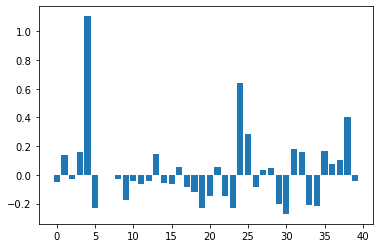

In [173]:
importance = modelo_final_log.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01646
Feature: 4, Score: 0.62011
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.02930
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.02104
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

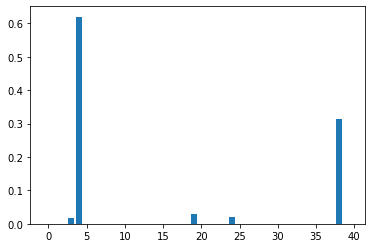

In [192]:
importance = modelo_final_tree.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))


plt.bar([x for x in range(len(importance))], importance)
plt.show()

En general todos los algoritmos utilizados tuvieron un rendimiento aceptable. 

Mención especial para la regresión logística que nos viene indicando que el feature 4, 24 y 39: la duración del contacto, el contacto por celular, y poutcome exitoso se relaciona a los clientes que elijen realizar el depósito fijo en nuestra institución

In [220]:
ab = list(data_2.columns)

In [221]:
ab.remove("y")

In [223]:
for i in enumerate(ab):
    print(i)

(0, 'age')
(1, 'education')
(2, 'balance')
(3, 'day')
(4, 'duration')
(5, 'campaign')
(6, 'pdays')
(7, 'previous')
(8, 'job_admin.')
(9, 'job_blue-collar')
(10, 'job_entrepreneur')
(11, 'job_housemaid')
(12, 'job_management')
(13, 'job_retired')
(14, 'job_self-employed')
(15, 'job_services')
(16, 'job_student')
(17, 'job_technician')
(18, 'job_unemployed')
(19, 'marital_married')
(20, 'marital_single')
(21, 'default_yes')
(22, 'housing_yes')
(23, 'loan_yes')
(24, 'contact_cellular')
(25, 'contact_telephone')
(26, 'month_aug')
(27, 'month_dec')
(28, 'month_feb')
(29, 'month_jan')
(30, 'month_jul')
(31, 'month_jun')
(32, 'month_mar')
(33, 'month_may')
(34, 'month_nov')
(35, 'month_oct')
(36, 'month_sep')
(37, 'poutcome_other')
(38, 'poutcome_success')
(39, 'poutcome_unknown')


# Cross Validation Excersice

In [ ]:
cv = ShuffleSplit(n_splits=20, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    # SGDClassifier(),
    LinearSVC(loss='hinge', tol=0.00001, C=0.2),
    # RandomForestClassifier(),
    # MLPClassifier()
]

sm = SMOTE()

# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)

Evaluacion

In [ ]:
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. F1 Score: {avg_f1:.2f}
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

In [ ]:
# podriamos probar de hacer un grafico de barras con el promedio de cross validation de todos los modelos